In [11]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from tensorboardX import SummaryWriter
import tqdm
import os
import uuid
import random
import matplotlib.pyplot as plt

use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
IntTensor = torch.cuda.IntTensor if use_cuda else torch.IntTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

unique_id = str(uuid.uuid4())

plot = plt.figure()

def weights_initialize(module):
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight, gain=nn.init.calculate_gain('relu'))
        module.bias.data.fill_(0.01)
        
class _TransModel(nn.Module):
    """ Model for DQN """

    def __init__(self, input_len, output_len):
        super(_TransModel, self).__init__()
        
        self.fc1 = nn.Sequential(
            torch.nn.Linear(input_len, 512),
            torch.nn.BatchNorm1d(512),
            nn.ReLU()
        )
        self.fc1.apply(weights_initialize)
        
        self.fc2 = nn.Sequential(
            torch.nn.Linear(512, 128),
            # torch.nn.BatchNorm1d(128),
            nn.ReLU()
        )
        self.fc2.apply(weights_initialize)
        
        self.output_layer = nn.Sequential(
            torch.nn.Linear(128, output_len)
        )
        self.output_layer.apply(weights_initialize)
        
    def forward(self, input):
        x = self.fc1(input)
        x = self.fc2(x)
        
        return self.output_layer(x)

class TransModel():
    def __init__(self, input_len, ouput_len, learning_rate = 0.0001):
        self.model = _TransModel(input_len, ouput_len)
        
        if use_cuda:
            print("Using GPU")
            self.model = self.model.cuda()
        else:
            print("Using CPU")
        self.steps = 0
        # self.model = nn.DataParallel(self.model)
        self.optimizer = Adam(self.model.parameters(), lr = learning_rate)
        self.loss_fn = nn.MSELoss(reduction='mean')
        
        self.steps = 0
        
    def predict(self, input, steps, learning):
        
        output = self.model(input).squeeze(1)
        #reward, next_state = output[0], output[1:]

        return output

    def predict_batch(self, input):
        output = self.model(input)
        #reward, next_state = output[:, 0], output[:, 1:]
        return output

    def fit(self, state, target_state):
        loss = self.loss_fn(state, target_state)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.steps += 1
        return loss

<Figure size 432x288 with 0 Axes>

In [12]:
def dot_plot(x, y, fig, style = 'o'):
    x = x * 2000
    y = y * 2000
    legend = [
                "Match line",
                "HP",
             ]
    fig=plt.figure(figsize=(15, 15), dpi= 160, facecolor='w', edgecolor='k')

    ax = plt.subplot(111)
    ax.set_ylim([-100,2100])
    ax.set_xlim([-100,2100])
    ax.plot(list(range(-100, 2100)),list(range(-100,2100)), "b--", alpha=0.05)
    for i in range(len(legend) - 1):
        #plt.plot(x[:, i].view(-1).tolist(), y[:, i].view(-1).tolist(), style, s = 0.1)
        ax.scatter(x[:, i].view(-1).tolist(), y[:, i].view(-1).tolist(),s = 0.5)

    plt.title('F1 Prediction')
    plt.legend(legend, bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
    plt.xlabel("Ground Truth")
    plt.ylabel("Prediction")
    chartBox = ax.get_position()
    ax.set_position([chartBox.x0, chartBox.y0, chartBox.width, chartBox.height])
    ax.legend(legend, loc='center left', bbox_to_anchor=(1, 0.8), shadow=True, ncol=1)

    return plt

In [13]:
def evaluation(model, data, epoch):
    state_action = torch.from_numpy(np.stack(data[:, 0])).type(FloatTensor)
    next_state_reward = torch.from_numpy(np.stack(data[:, 1])).type(FloatTensor)
    
    model.model.eval()
    criterion = nn.MSELoss(reduction='mean')
    
    outputs = model.predict_batch(state_action)

    mse = criterion(outputs, next_state_reward)

    accuracy = torch.sum( torch.sum( torch.eq( outputs, next_state_reward ) )).item()
    accuracy = accuracy / (2 * outputs.size()[0])

    if epoch % 1000 == 0:
        p = dot_plot(next_state_reward, outputs, plot)
        p.show()
    model.model.train()
    
    summary_test.add_scalar("MSE", float(mse.item()), epoch)
   # summary_test.add_scalars("MSE",{'Baseline Nexus HP MSE': float(mse_baseline)}, epoch)

    summary_test.add_scalars("MSE",{'Nexus HP MSE': float(mse.item())}, epoch)
   
    f = open("nexus-HP-transition-model-report/test_loss.txt", "a+")
    f.write("loss:" + str(mse.item()) + ", ")
    f.write("acc:" + str(accuracy) + "\n")
    if epoch % 1000 == 0:
        f.write("output:" + str(outputs[0:2]) + "\n")
        f.write("ground true:" + str(next_state_reward[0:2]) + "\n")
    f.close()
    return mse.item()

In [14]:
data = torch.load('all_experiences_grid.pt')
np.set_printoptions(suppress=True)
l = len(data)

one_nexus_perspective = [[[],[]] for _ in range(len(data)*4)] # Format data into the state of the lane from the perspective of a single nexus, ground truth is the opposite nexus HP

j = 0
for i in range(0, len(data)):
    #data[i][1] = [ data[i][1][63] / 2000 , data[i][1][64] / 2000 , data[i][1][65] / 2000 , data[i][1][66] / 2000 ]
    
    data[i][0][0:4] = np.true_divide( data[i][0][0:4], 30) # Normalize P1 top buildings
    data[i][0][5:9] = np.true_divide( data[i][0][5:9], 30) # Normalize P2 top buildings
    
    data[i][0][0:4] = np.true_divide( data[i][0][0:4], 30) # Normalize P1 bottom buildings
    data[i][0][5:9] = np.true_divide( data[i][0][5:9], 30) # Normalize P2 bottom buildings
    
    data[i][0][63] = data[i][0][63] / 2000 # Normalize P1 Top Nexus HP
    data[i][0][64] = data[i][0][64] / 2000 # Normalize P2 Top Nexus HP
    
    data[i][0][65] = data[i][0][65] / 2000 # Normalize P1 Bottom Nexus HP
    data[i][0][66] = data[i][0][66] / 2000 # Normalize P2 Bottom Nexus HP

    data[i][0][0] = data[i][0][10] / 1500 # Normalize P1 Minerals
    
    # Re-split into nexus perspective
    j = i * 4
    # Perspective of P1 Top
    one_nexus_perspective[j][0] = np.concatenate((
                                                    data[i][0][1:4],   # P1 top buildings
                                                    data[i][0][7],     # P1 pylon
                                                    data[i][0][8:11],  # P2 top buildings
                                                    data[i][0][14],    # P2 pylon
                                                    data[i][0][15:27], # P1 Grid 1-4 top
                                                    data[i][0][39:51], # P2 Grid 1-4 top
                                                    data[i][0][63],    # P1 Top Nexus HP
                                                    data[i][0][65],    # P2 Top Nexus HP
                                                    data[i][0][67]     # Wave number
                                                  ), axis=None)
    # Perspective of P1 Top, ground truth = P2 Top
    one_nexus_perspective[j][1] = np.concatenate((
                                                    data[i][1][65] / 2000, # GT P2 Top Lane
                                                ), axis=None)
    # Perspective of P1 Bottom
    one_nexus_perspective[j+1][0] = np.concatenate((
                                                    data[i][0][4:7],   # P1 bottom buildings
                                                    data[i][0][7],     # P1 pylon
                                                    data[i][0][11:14], # P2 bottom buildings
                                                    data[i][0][14],    # P2 pylon
                                                    data[i][0][27:39], # P1 Grid 1-4 bottom
                                                    data[i][0][51:63], # P2 Grid 1-4 bottom
                                                    data[i][0][64],    # P1 bottom Nexus HP
                                                    data[i][0][66],    # P2 bottom Nexus HP
                                                    data[i][0][67]     # Wave number
                                                  ), axis=None)
    # Perspective of P1 Bottom, ground truth = P2 Bottom
    one_nexus_perspective[j+1][1] = np.concatenate((
                                                    data[i][1][66] / 2000, # GT P2 Bottom Lane
                                                ), axis=None) 
    # Perspective of P2 Top
    one_nexus_perspective[j+2][0] = np.concatenate((
                                                    data[i][0][8:11],  # P2 top buildings
                                                    data[i][0][14],    # P2 pylon
                                                    data[i][0][1:4],   # P1 top buildings
                                                    data[i][0][7],     # P1 pylon
                                                    np.flip(data[i][0][39:51]), # P2 Grid 1-4 top
                                                    np.flip(data[i][0][15:27]), # P1 Grid 1-4 top
                                                    data[i][0][65],    # P2 Top Nexus HP
                                                    data[i][0][63],    # P1 Top Nexus HP
                                                    data[i][0][67]     # Wave number
                                                  ), axis=None)
    # Perspective of P2 Top, ground truth = P1 Top
    one_nexus_perspective[j+2][1] =  np.concatenate((
                                                    data[i][1][63] / 2000, # GT P1 Top Lane
                                                ), axis=None)
    # Perspective of P2 Bottom
    one_nexus_perspective[j+3][0] =  np.concatenate((
                                                    data[i][0][11:14], # P2 bottom buildings
                                                    data[i][0][14],    # P2 pylon
                                                    data[i][0][4:7],   # P1 bottom buildings
                                                    data[i][0][7],     # P1 pylon
                                                    np.flip(data[i][0][51:63]), # P2 Grid 1-4 bottom
                                                    np.flip(data[i][0][27:39]), # P1 Grid 1-4 bottom
                                                    data[i][0][66],    # P2 bottom Nexus HP
                                                    data[i][0][64],    # P1 bottom Nexus HP
                                                    data[i][0][67]     # Wave number
                                                  ), axis=None) 
    # Perspective of P2 Bottom, ground truth = P1 Bottom
    one_nexus_perspective[j+3][1] = np.concatenate((
                                                    data[i][1][64] / 2000, # GT P1 Bottom Lane
                                                ), axis=None) 

print(data[0][0])
#print(len(data[0][0]))
print(data[0][1])
print()
print(one_nexus_perspective[0][0])
print(one_nexus_perspective[0][1])
print()
print(one_nexus_perspective[1][0].shape)
print(one_nexus_perspective[1][1])
print()
print(one_nexus_perspective[2][0].shape)
print(one_nexus_perspective[2][1])
print()
print(one_nexus_perspective[3][0].shape)
print(one_nexus_perspective[3][1])

np.random.shuffle(one_nexus_perspective)

l = len(one_nexus_perspective)

#train_data = np.array(one_nexus_perspective[: int(np.floor(l * 0.8))])
test_data = np.array(one_nexus_perspective[int(np.floor(l * 0.8)) : ])

print(train_data.shape, test_data.shape)

batch_size = 128
summary_test = SummaryWriter(log_dir = 'nexus-HP-transition-model-report/')

[0.         0.         0.00222222 0.         0.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         1.         1.
 1.         2.        ]
[ 100.    0.    2.    0.    0.    0.    0.    0.    0.    1.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    2.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0

Using GPU


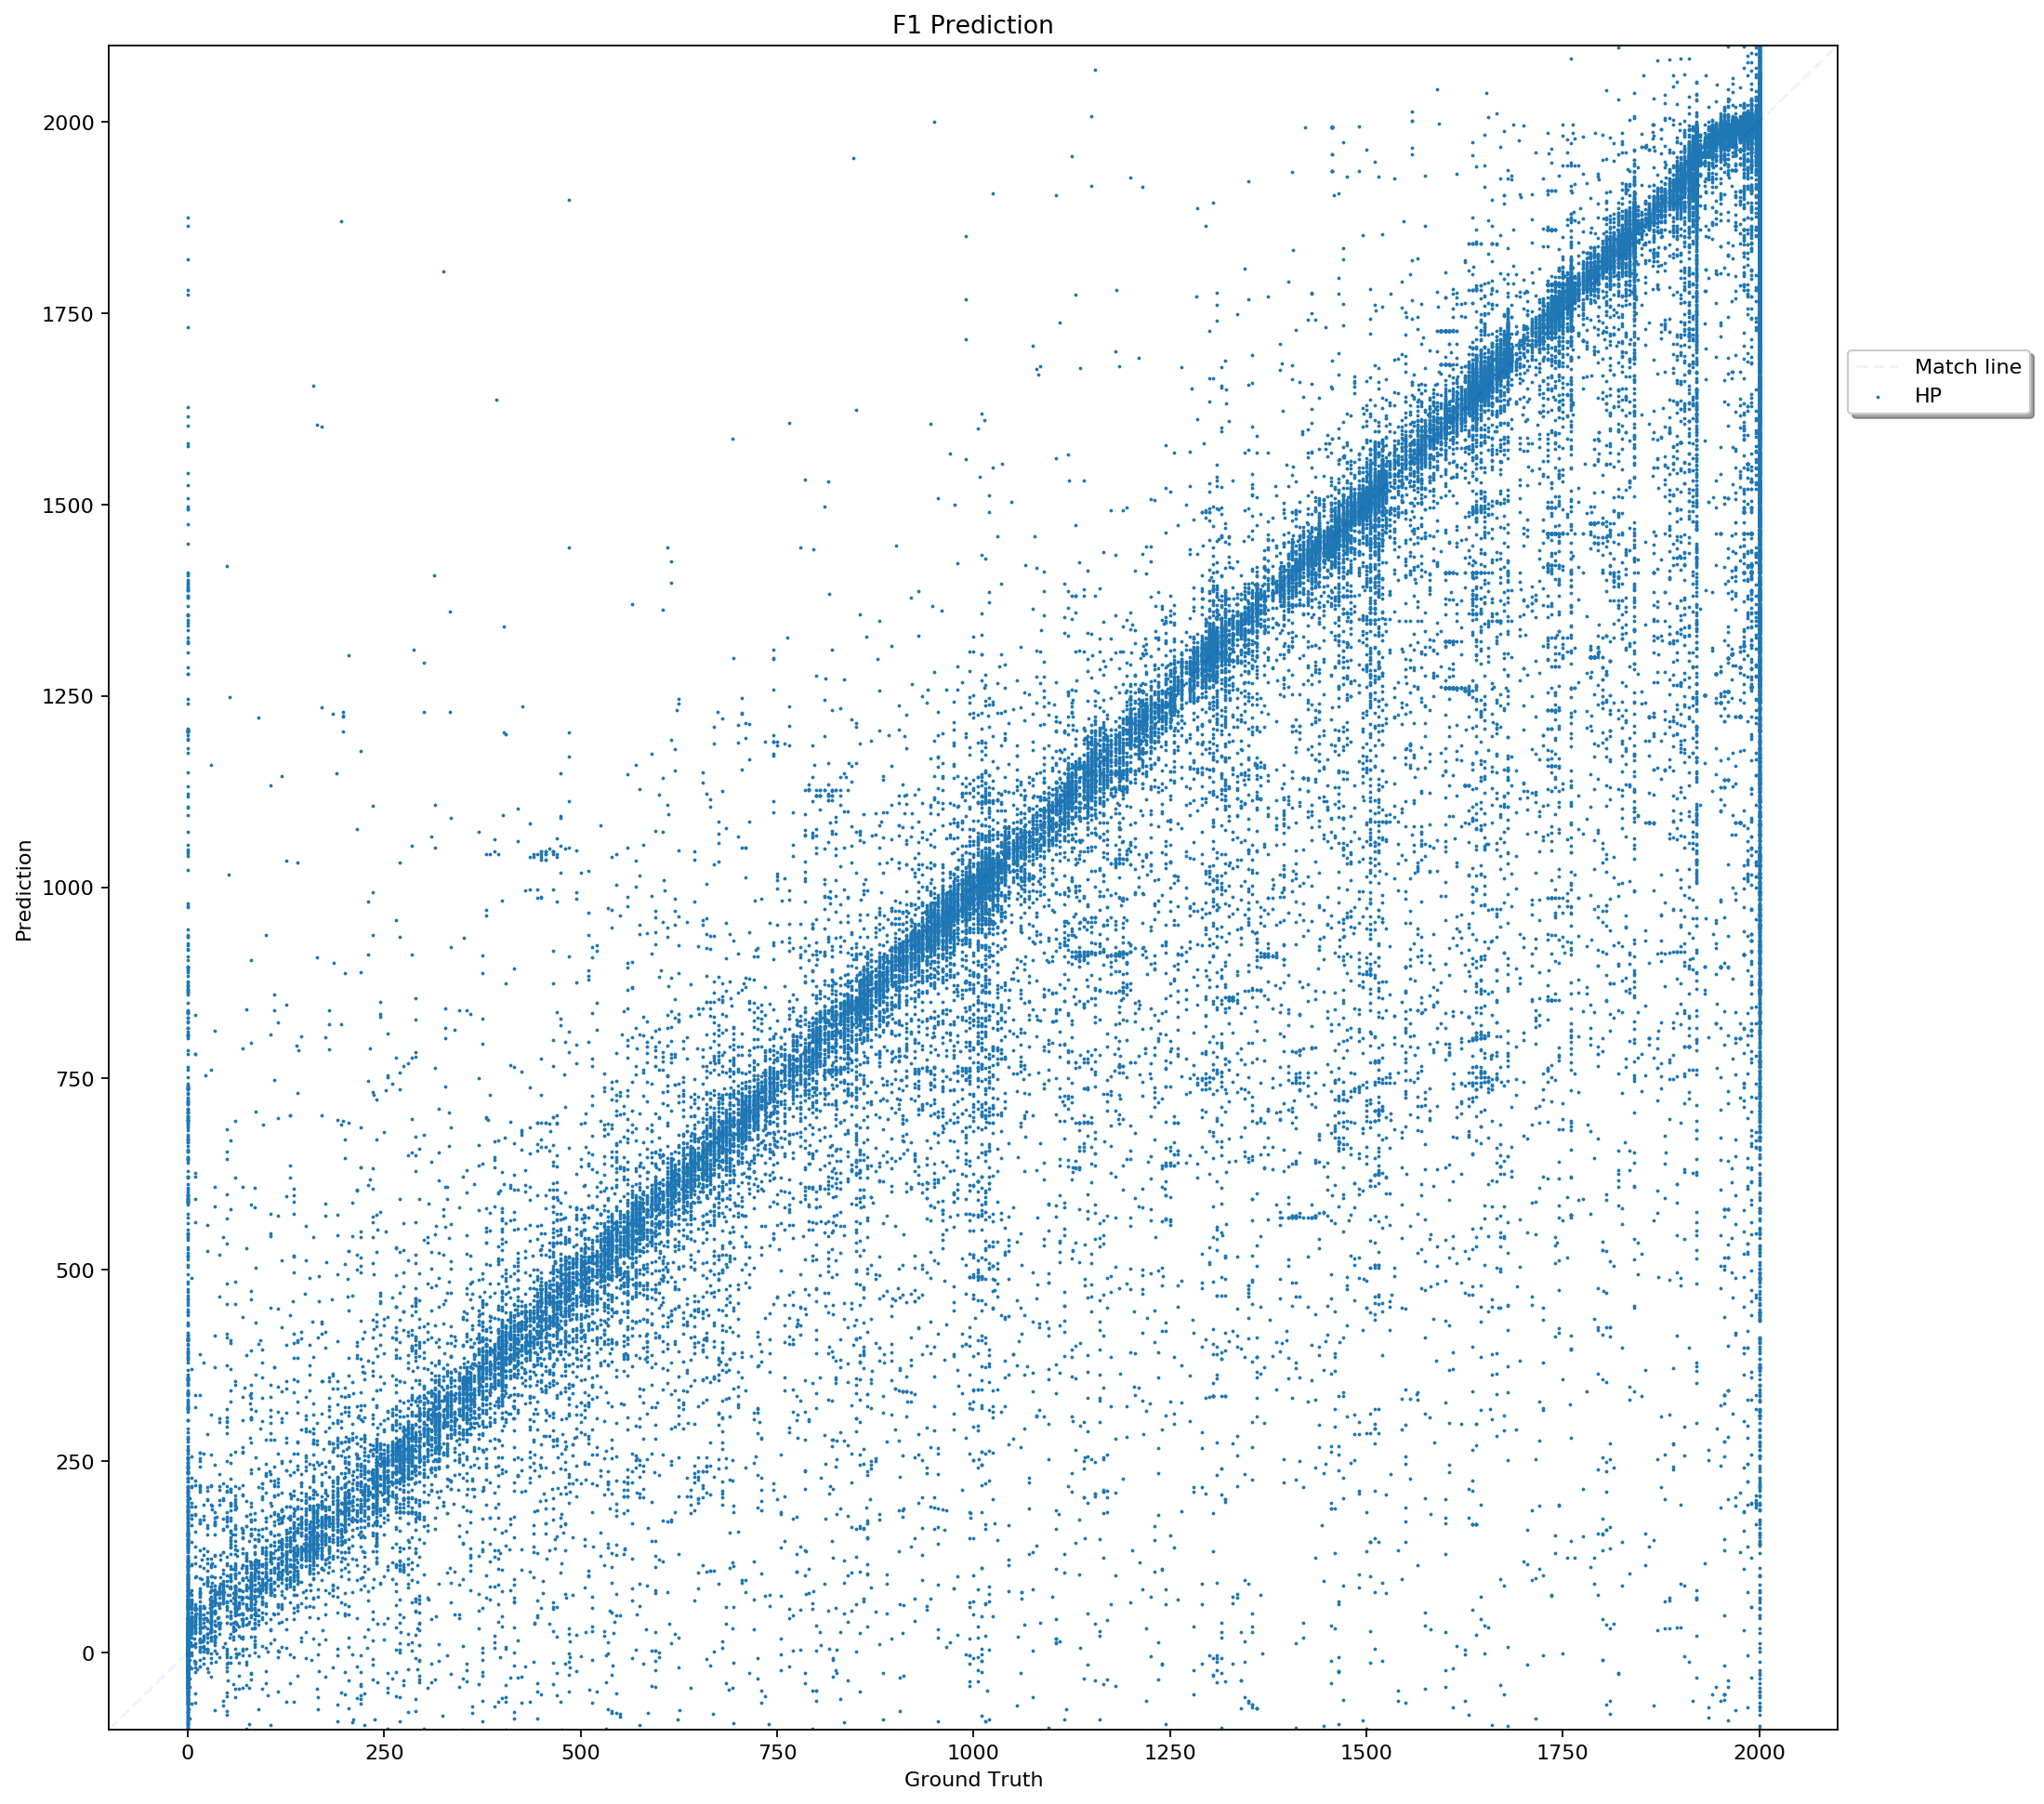

0.046912964433431625

In [15]:
check_model = TransModel(len(one_nexus_perspective[0][0]), len(one_nexus_perspective[0][1]))

check_model.model.load_state_dict(torch.load('../models_mb/nexus-HP-transition-model-predict-4.pt'))

evaluation(check_model, test_data, 0)